# Installing the required packages

In [ ]:
import gensim

In [ ]:
print(gensim.__version__)

4.2.0


In [ ]:
pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 72.0 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
!pip install keras-tcn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.0 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GRU, Dropout, Bidirectional, SpatialDropout1D, GlobalAveragePooling1D,GlobalMaxPooling1D
from tensorflow.keras.utils import to_categorical
from keras.layers import concatenate
from sklearn import preprocessing

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics

import matplotlib.pyplot as plt
import keras.backend as K
import keras.layers
from keras import optimizers
from tensorflow.keras.layers import Layer, InputSpec

from keras.layers import Activation, Lambda
from keras.layers import Conv1D, SpatialDropout1D
from keras.layers import Convolution1D, Dense
from keras.models import Model
from typing import List, Tuple

# Read Dataset

In [ ]:
main = pd.read_csv('/content/drive/MyDrive/Clickbait/Text_Dataset/Main_Dataset.csv')
val = pd.read_csv('/content/drive/MyDrive/Clickbait/Text_Dataset/Validation_Dataset.csv')

In [ ]:
df= main.append(val, ignore_index=True)

In [ ]:
df.head()

,postMedia,postText,id,targetCaptions,targetParagraphs,targetTitle,postTimestamp,targetKeywords,targetDescription,truthJudgments,truthMean,truthClass,truthMedian,truthMode
0,['media/photo_858153570478305281.jpg'],"[""Malls are dying, but it's hard to profit fro...",858153572571197440,[],['Lisa Abramowicz is a Bloomberg Gadfly column...,This Big Short Threatens to Be a Big Bust,Sat Apr 29 02:58:50 +0000 2017,"Infrastructure,Debt,Real Estate,Fund Manager,W...","The wager worked early on, but time is working...","[0.33333333330000003, 0.0, 0.6666666666000001,...",0.333333,no-clickbait,0.333333,0.333333
1,['media/photo_858137808657108992.jpg'],['The top 10 best selling comic books of all t...,858137811039465472,[],"['More', 'By Brian Prowse-Gany', 'In celebrati...",The top 10 best selling comic books of all tim...,Sat Apr 29 01:56:12 +0000 2017,NaN,"In celebration of National Superhero Day, Yaho...","[0.6666666666000001, 1.0, 1.0, 0.0, 1.0]",0.733333,clickbait,1.000000,1.000000
2,['media/photo_858069152451354625.jpg'],"['Players to know, QBs to watch and more 👀\n\n...",858070460814184448,['NFL Draft logo'],['The first round of the 2017 NFL draft was no...,B/R Presents: NFL1000 Guide to Day 2 of the 20...,Fri Apr 28 21:28:34 +0000 2017,"NFL Draft, NFL, Preview Prediction",The first round of the 2017 NFL draft was no...,"[1.0, 0.6666666666000001, 0.6666666666000001, ...",0.600000,clickbait,0.666667,0.666667
3,['media/photo_858033549995376641.jpg'],['Florida officials say no Zika virus has been...,858033553468252160,['PHOTO: A mosquito is pictured on a persons a...,"['With summer approaching, Florida health offi...",No Zika detected in Florida mosquitoes so far ...,Fri Apr 28 19:01:55 +0000 2017,"zika, florida, mosquitoes, health news, medica...","With summer approaching, officials are hoping ...","[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,no-clickbait,0.000000,0.000000
4,['media/photo_857902230321725440.jpg'],['White House reporter @alivitali on her first...,857902233232527360,"['TODAY', 'Image: NBC News reporter Ali Vitali...",['The most consistent thing about my life for ...,My 100 Days of Covering President Donald Trump,Fri Apr 28 10:20:06 +0000 2017,NaN,"For the past 100 days, my ""office"" has been th...","[0.33333333330000003, 0.0, 0.6666666666000001,...",0.533333,clickbait,0.666667,0.666667


In [ ]:
text = df['targetTitle'].values         # Input Feature (Title of media posts)
labels = df['truthClass'].values        # Target Class/label

# Train test split

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(text, labels,test_size=0.33, random_state=0)

In [ ]:
X_train

array(['5 travel credit card sign-up bonuses to fund your summer trip',
       '17 Limited-Edition Beauty Products You Need To Buy\xa0ASAP',
       'After Pre-Election Surge, Apprehensions at Southern Border Hit Five-Year Low',
       ...,
       '4 Ways Entrepreneurs Can Use Technology To Stay Fit On The Road',
       "Beliebers Can't Get Over Justin Bieber's Four Grammy Nominations: See Their Tweets",
       "Parents Welcome New Year's Twins Born Minutes Apart, in Different Years "],
      dtype=object)

# Word2Vec Embedding

In [ ]:
# Train the word2vec model
w2v_model = gensim.models.Word2Vec(X_train,
                                   vector_size=100,
                                   window=5,
                                   min_count=2)

In [ ]:
words = set(w2v_model.wv.index_to_key )
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


In [ ]:
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

# Encoding Target Variable

In [ ]:
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
y_train_en= label_encoder.fit_transform(y_train)

y_test_en = label_encoder.transform(y_test)

target_length = y_train_en.shape

In [ ]:
X_train.shape

(14206,)

In [ ]:
X_train_vect_avg=np.array(X_train_vect_avg)
X_train_vect_avg = X_train_vect_avg[:, np.newaxis]

In [ ]:
X_train_vect_avg.shape

(14206, 1, 100)

# Defining TCN Layer

In [ ]:
def channel_normalization(x):
    # type: (Layer) -> Layer
    """ Normalize a layer to the maximum activation
    This keeps a layers values between zero and one.
    It helps with relu's unbounded activation
    Args:
        x: The layer to normalize
    Returns:
        A maximal normalized layer
    """
    max_values = K.max(K.abs(x), 2, keepdims=True) + 1e-5
    out = x / max_values
    return out


def wave_net_activation(x):
    # type: (Layer) -> Layer
    """This method defines the activation used for WaveNet
    described in https://deepmind.com/blog/wavenet-generative-model-raw-audio/
    Args:
        x: The layer we want to apply the activation to
    Returns:
        A new layer with the wavenet activation applied
    """
    tanh_out = Activation('tanh')(x)
    sigm_out = Activation('sigmoid')(x)
    return keras.layers.multiply([tanh_out, sigm_out])


def residual_block(x, s, i, activation, nb_filters, kernel_size, padding, dropout_rate=0, name=''):
    # type: (Layer, int, int, str, int, int, float, str) -> Tuple[Layer, Layer]
    """Defines the residual block for the WaveNet TCN
    Args:
        x: The previous layer in the model
        s: The stack index i.e. which stack in the overall TCN
        i: The dilation power of 2 we are using for this residual block
        activation: The name of the type of activation to use
        nb_filters: The number of convolutional filters to use in this block
        kernel_size: The size of the convolutional kernel
        padding: The padding used in the convolutional layers, 'same' or 'causal'.
        dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
        name: Name of the model. Useful when having multiple TCN.
    Returns:
        A tuple where the first element is the residual model layer, and the second
        is the skip connection.
    """

    original_x = x
    conv = Conv1D(filters=nb_filters, kernel_size=kernel_size,
                  dilation_rate=i, padding=padding,
                  name=name + '_dilated_conv_%d_tanh_s%d' % (i, s))(x)
    if activation == 'norm_relu':
        x = Activation('relu')(conv)
        x = Lambda(channel_normalization)(x)
    elif activation == 'wavenet':
        x = wave_net_activation(conv)
    else:
        x = Activation(activation)(conv)

    x = SpatialDropout1D(dropout_rate, name=name + '_spatial_dropout1d_%d_s%d_%f' % (i, s, dropout_rate))(x)

    # 1x1 conv.
    x = Convolution1D(nb_filters, 1, padding='same')(x)
    res_x = keras.layers.add([original_x, x])
    return res_x, x


def process_dilations(dilations):
    def is_power_of_two(num):
        return num != 0 and ((num & (num - 1)) == 0)

    if all([is_power_of_two(i) for i in dilations]):
        return dilations

    else:
        new_dilations = [2 ** i for i in dilations]
        # print(f'Updated dilations from {dilations} to {new_dilations} because of backwards compatibility.')
        return new_dilations


class TCN:
    """Creates a TCN layer.
        Args:
            input_layer: A tensor of shape (batch_size, timesteps, input_dim).
            nb_filters: The number of filters to use in the convolutional layers.
            kernel_size: The size of the kernel to use in each convolutional layer.
            dilations: The list of the dilations. Example is: [1, 2, 4, 8, 16, 32, 64].
            nb_stacks : The number of stacks of residual blocks to use.
            activation: The activations to use (norm_relu, wavenet, relu...).
            padding: The padding to use in the convolutional layers, 'causal' or 'same'.
            use_skip_connections: Boolean. If we want to add skip connections from input to each residual block.
            return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
            dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
            name: Name of the model. Useful when having multiple TCN.
        Returns:
            A TCN layer.
        """

    def __init__(self,
                 nb_filters=64,
                 kernel_size=2,
                 nb_stacks=1,
                 dilations=None,
                 activation='norm_relu',
                 padding='causal',
                 use_skip_connections=True,
                 dropout_rate=0.0,
                 return_sequences=True,
                 name='tcn'):
        self.name = name
        self.return_sequences = return_sequences
        self.dropout_rate = dropout_rate
        self.use_skip_connections = use_skip_connections
        self.activation = activation
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters
        self.padding = padding

        # backwards incompatibility warning.
        # o = tcn.TCN(i, return_sequences=False) =>
        # o = tcn.TCN(return_sequences=False)(i)

        if padding != 'causal' and padding != 'same':
            raise ValueError("Only 'causal' or 'same' paddings are compatible for this layer.")

        if not isinstance(nb_filters, int):
            print('An interface change occurred after the version 2.1.2.')
            print('Before: tcn.TCN(i, return_sequences=False, ...)')
            print('Now should be: tcn.TCN(return_sequences=False, ...)(i)')
            print('Second solution is to pip install keras-tcn==2.1.2 to downgrade.')
            raise Exception()

    def __call__(self, inputs):
        if self.dilations is None:
            self.dilations = [1, 2, 4, 8, 16, 32]
        x = inputs
        x = Convolution1D(self.nb_filters, 1, padding=self.padding, name=self.name + '_initial_conv')(x)
        skip_connections = []
        for s in range(self.nb_stacks):
            for i in self.dilations:
                x, skip_out = residual_block(x, s, i, self.activation, self.nb_filters,
                                             self.kernel_size, self.padding, self.dropout_rate, name=self.name)
                skip_connections.append(skip_out)
        if self.use_skip_connections:
            x = keras.layers.add(skip_connections)
        x = Activation('relu')(x)

        if not self.return_sequences:
            output_slice_index = -1
            x = Lambda(lambda tt: tt[:, output_slice_index, :])(x)
        return x

# TCN Model

In [ ]:
inp = Input(shape=X_train_vect_avg[0].shape)
#model.add(Dense(100, activation='relu',input_shape=X_train_vect_avg[0].shape))
#x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
x = SpatialDropout1D(0.1)(inp)
x = TCN(128,dilations = [1, 2, 4], return_sequences=True, activation = 'wavenet',name = 'tnc1')(x)
x = TCN(64,dilations = [1, 2, 4], return_sequences=True, activation = 'wavenet',name = 'tnc2')(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)

conc = concatenate([avg_pool, max_pool])
conc = Dense(16, activation="relu")(conc)
conc = Dropout(0.1)(conc)
outp = Dense(1, activation="sigmoid")(conc)    

model = Model(inputs=inp, outputs=outp)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 1, 100)]     0           []                               
                                                                                                  
 spatial_dropout1d_4 (SpatialDr  (None, 1, 100)      0           ['input_12[0][0]']               
 opout1D)                                                                                         
                                                                                                  
 tnc1_initial_conv (Conv1D)     (None, 1, 128)       12928       ['spatial_dropout1d_4[0][0]']    
                                                                                                  
 tnc1_dilated_conv_1_tanh_s0 (C  (None, 1, 128)      32896       ['tnc1_initial_conv[0][0]']

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

history = model.fit(X_train_vect_avg, y_train_en, epochs=5, 
                    validation_split=0.3, 
                    callbacks=[callback])

Epoch 1/5
311/311 [==============================] - 7s 15ms/step - loss: 0.5031 - accuracy: 0.7872 - val_loss: 0.5180 - val_accuracy: 0.7766
Epoch 2/5
311/311 [==============================] - 6s 19ms/step - loss: 0.4914 - accuracy: 0.7910 - val_loss: 0.4918 - val_accuracy: 0.7759
Epoch 3/5
311/311 [==============================] - 4s 13ms/step - loss: 0.4907 - accuracy: 0.7905 - val_loss: 0.4867 - val_accuracy: 0.7825
Epoch 4/5
311/311 [==============================] - 4s 14ms/step - loss: 0.4856 - accuracy: 0.7918 - val_loss: 0.4882 - val_accuracy: 0.7865


# Testing and Prediction

In [ ]:
X_test_vect_avg=np.array(X_test_vect_avg)
X_test_vect_avg = X_test_vect_avg[:, np.newaxis]

In [ ]:
# Use the trained model to make predictions on the test data
y_pred = model.predict(X_test_vect_avg)

219/219 [==============================] - 1s 4ms/step


In [ ]:
y_pred

array([[0.8588047 ],
       [0.79877514],
       [0.8529892 ],
       ...,
       [0.4197152 ],
       [0.74971104],
       [0.77022314]], dtype=float32)

In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred

array([1, 1, 1, ..., 0, 1, 1])

# Metrics

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test_en, y_pred)
recall = recall_score(y_test_en, y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test_en).sum()/len(y_pred), 3)))

Precision: 0.803 / Recall: 0.96 / Accuracy: 0.786


# Confusion Matrix

accuracy: 0.786


<Figure size 432x288 with 0 Axes>

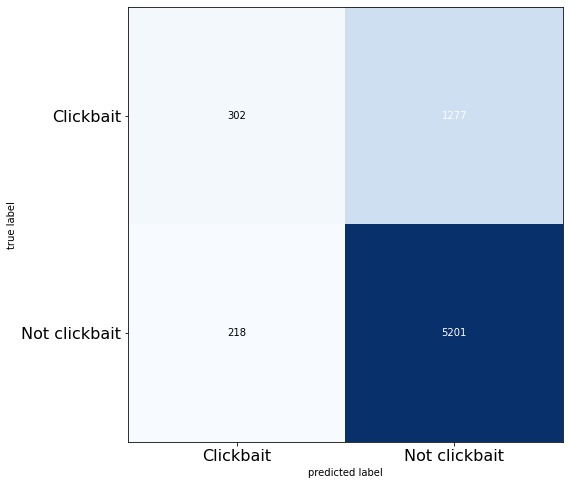

In [ ]:
accuracy=metrics.accuracy_score(y_test_en,y_pred)
print('accuracy: %0.3f'%accuracy)
cm=metrics.confusion_matrix(y_test_en, y_pred)
#plot_confusion_matrix(cm , classes=['FAKE','TRUE'])
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Clickbait','Not clickbait'], fontsize=16)
plt.yticks(range(2), ['Clickbait','Not clickbait'], fontsize=16)
plt.show()

# Accuracy Plot

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_en, y_pred, target_names=['Clickbait','Not clickbait']))

               precision    recall  f1-score   support

    Clickbait       0.58      0.19      0.29      1579
Not clickbait       0.80      0.96      0.87      5419

     accuracy                           0.79      6998
    macro avg       0.69      0.58      0.58      6998
 weighted avg       0.75      0.79      0.74      6998

